In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# %cd "/content/drive/MyDrive/TrainingData.zip"
# !unzip TrainingData.zip

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import os
from PIL import Image
import glob

# Set parameters
image_size = (256, 256)
sample_rate = 61.44e6
num_sub_frames = 40
frame_duration = num_sub_frames * 1e-3  # seconds
train_dir = os.path.join(os.getcwd(), 'TrainingData')
print(train_dir)


trainDir = '/content/drive/MyDrive/TrainingData/'
image_files = [os.path.join(trainDir, f) for f in os.listdir(trainDir) if f.endswith('.png')]

# Function to load images from a directory
def load_images_from_folder(folder, ext='.png'):
    images = []
    image_paths = []
    for filename in glob.glob(os.path.join(folder, f'*{ext}')):
      try:
        with Image.open(filename) as img:
            images.append(img.copy())
      except Exception as e:
        print(f"Error loading image {filename}: {e}")
    return images

# Load Training Data
imds = load_images_from_folder(train_dir, ext='.png')
print(len(imds))


/content/drive/MyDrive/TrainingData
1800


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

trainDir = '/content/drive/MyDrive/TrainingData'
label_files = [os.path.join(trainDir, f) for f in os.listdir(trainDir) if f.endswith('.hdf')]

# Function to read an image file
def read_label(file_path):
    dataset = gdal.Open(file_path)
    band = dataset.GetRasterBand(1)
    return band.ReadAsArray()

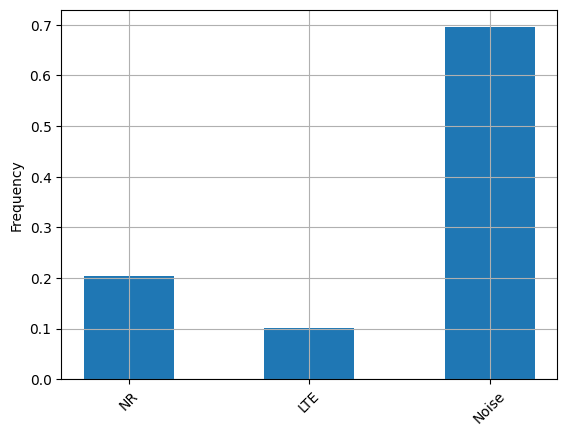

In [ ]:
pixel_to_class = {127: "NR", 255: "LTE", 0: "Noise"}

# Initialize a dictionary to hold counts for each class
class_counts = {"NR": 0, "LTE": 0, "Noise": 0}

# Iterate over each image file and count pixels
for file in label_files:
    label_data = read_label(file)
    for value, class_name in pixel_to_class.items():
        class_counts[class_name] += np.sum(label_data == value)

# Calculate frequencies
total_pixels = sum(class_counts.values())
frequencies = {k: v / total_pixels for k, v in class_counts.items()}

# Plotting
labels, values = zip(*frequencies.items())
indexes = np.arange(len(labels))
width = 0.5

# Calculate total number of samples
total_samples = sum(class_counts.values())
num_classes = 3
# Calculate class weights
class_weights = {class_id: total_samples / (num_classes * class_counts[class_name])
                 for class_id, class_name in enumerate(class_counts.keys())}

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=45)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import os

def align_files(image_files, label_files):

    # Extract base names without extensions
    base_to_image = {os.path.splitext(os.path.basename(file))[0]: file for file in image_files}
    base_to_label = {os.path.splitext(os.path.basename(file))[0]: file for file in label_files}

    # Align the files based on base names
    aligned_images = []
    aligned_labels = []

    for base_name in base_to_image:
        if base_name in base_to_label:
            aligned_images.append(base_to_image[base_name])
            aligned_labels.append(base_to_label[base_name])

    return aligned_images, aligned_labels

image_files, label_files = align_files(image_files, label_files)
print(len(label_files))

1800


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import lr_scheduler
from torchvision.models.segmentation import deeplabv3_resnet50

In [ ]:
from osgeo import gdal
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class ImageLabelDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image using PIL
        image = Image.open(self.image_paths[idx]).convert('L')

        image = np.array(image)
        image = np.stack([image, image, image], axis=-1)  # Stack the grayscale image 3 times

        # Convert to PIL image
        image = Image.fromarray(image)

        label_dataset = gdal.Open(self.label_paths[idx])
        if label_dataset is None:
            raise FileNotFoundError(f"Unable to open file: {self.label_paths[idx]}")

        # Load the label using GDAL
        label_dataset = gdal.Open(self.label_paths[idx])
        label_array = label_dataset.ReadAsArray()
        label = np.array(label_array).astype(np.uint8)
        # Map label values
        label[label == 127] = 1  # NR
        label[label == 255] = 2  # LTE

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            label = torch.from_numpy(label).long()

        return image, label


In [ ]:
# Assuming image_paths and label_paths are lists of file paths
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageLabelDataset(image_files, label_files, transform)

def calculate_mean_std(loader):
    # Var[x] = E[X^2] - E^2[X]
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - E^2[X])
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Calculate the mean and std
mean, std = calculate_mean_std(dataloader)
print(mean)
print(std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Reinitialize the dataset with the transform
dataset = ImageLabelDataset(image_files, label_files, transform=transform)

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


tensor([0.4934, 0.4934, 0.4934])
tensor([0.1844, 0.1844, 0.1844])


In [ ]:
total_samples = sum(class_counts.values())
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts.values()]

# Convert class weights to tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive Path (Decoder)
        self.up_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.up_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Output layer
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)  # 3 output channels for 3 classes

    def forward(self, x):
        # Encoder
        e1 = F.relu(self.enc_conv1(x))
        e2 = F.relu(self.enc_conv2(self.pool(e1)))
        e3 = F.relu(self.enc_conv3(self.pool(e2)))
        e4 = F.relu(self.enc_conv4(self.pool(e3)))

        # Decoder
        d1 = F.relu(self.dec_conv1(torch.cat([self.up_conv1(e4), e3], dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.up_conv2(d1), e2], dim=1)))
        d3 = F.relu(self.dec_conv3(torch.cat([self.up_conv3(d2), e1], dim=1)))

        # Output
        out = self.out_conv(d3)
        return out




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet_V2(nn.Module):
    def __init__(self):
        super(UNet_V2, self).__init__()

        # Contracting Path (Encoder)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive Path (Decoder)
        self.up_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.up_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(64)

        # Output layer
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)  # 3 output channels for 3 classes

    def forward(self, x):
        # Encoder
        e1 = F.leaky_relu(self.bn1(self.enc_conv1(x)), negative_slope=0.01)
        e2 = F.leaky_relu(self.bn2(self.enc_conv2(self.pool(e1))), negative_slope=0.01)
        e3 = F.leaky_relu(self.bn3(self.enc_conv3(self.pool(e2))), negative_slope=0.01)
        e4 = F.leaky_relu(self.bn4(self.enc_conv4(self.pool(e3))), negative_slope=0.01)

        # Decoder
        d1 = F.leaky_relu(self.bn5(self.dec_conv1(torch.cat([self.up_conv1(e4), e3], dim=1))), negative_slope=0.01)
        d2 = F.leaky_relu(self.bn6(self.dec_conv2(torch.cat([self.up_conv2(d1), e2], dim=1))), negative_slope=0.01)
        d3 = F.leaky_relu(self.bn7(self.dec_conv3(torch.cat([self.up_conv3(d2), e1], dim=1))), negative_slope=0.01)

        # Output
        out = self.out_conv(d3)
        return out


In [ ]:
# Initialize the U-Net model
model = UNet_V2()

# Initialize the U-Net model
model = UNet_V2().to(device)

model.train()

criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device)) # Move the weights to the device
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)

# Setup the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
min_val_loss = float('inf')

num_epochs = 20  # Set the number of epochs
metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_pixels = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        print(images)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print(labels)
        total_correct += (predicted == labels).sum().item()
        total_pixels += torch.numel(labels)

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / total_pixels
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)

    # Validation step...
    # Calculate and append validation loss, precision, recall, and F1 score
    # Validation
    model.eval()
    val_loss, val_correct, val_pixels = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_pixels += torch.numel(labels)

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    val_loss /= len(val_loader)
    # Scheduler step with the validation loss
    scheduler.step(val_loss)

    # Early stopping logic
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), '/content/best_model_state_dict.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered after {} epochs without improvement".format(early_stopping_patience))
            break
    val_acc = val_correct / val_pixels
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    metrics['val_loss'].append(val_loss)
    metrics['val_precision'].append(precision)
    metrics['val_recall'].append(recall)
    metrics['val_f1'].append(f1)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_precision'], label='Validation Precision')
plt.plot(metrics['val_recall'], label='Validation Recall')
plt.plot(metrics['val_f1'], label='Validation F1 Score')
plt.legend()
plt.title('Metrics over Epochs')

plt.show()

tensor([[[[ 0.1526,  0.5779,  0.4077,  ...,  0.8543,  0.6204,  0.4715],
          [ 0.0462,  0.5566,  0.7693,  ...,  0.1313,  0.1526,  0.1738],
          [ 0.2163,  0.4715,  0.6417,  ...,  0.3865, -0.0388,  0.1951],
          ...,
          [ 0.4290,  0.2589,  0.1100,  ...,  0.0250,  0.1313,  0.4928],
          [ 0.1951,  0.4715,  0.4503,  ...,  0.1738,  0.3439,  0.1526],
          [ 0.6417,  0.4077, -0.0601,  ...,  0.0462,  0.1738,  0.2589]],

         [[ 0.1526,  0.5779,  0.4077,  ...,  0.8543,  0.6204,  0.4715],
          [ 0.0462,  0.5566,  0.7693,  ...,  0.1313,  0.1526,  0.1738],
          [ 0.2163,  0.4715,  0.6417,  ...,  0.3865, -0.0388,  0.1951],
          ...,
          [ 0.4290,  0.2589,  0.1100,  ...,  0.0250,  0.1313,  0.4928],
          [ 0.1951,  0.4715,  0.4503,  ...,  0.1738,  0.3439,  0.1526],
          [ 0.6417,  0.4077, -0.0601,  ...,  0.0462,  0.1738,  0.2589]],

         [[ 0.1526,  0.5779,  0.4077,  ...,  0.8543,  0.6204,  0.4715],
          [ 0.0462,  0.5566,  

KeyboardInterrupt: ignored

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testDir = '/content/drive/MyDrive/TrainingData/LTE_NR/'
test_dir = os.path.join(os.getcwd(), 'LTE_NR')
image_test_files = [os.path.join(testDir, f) for f in os.listdir(testDir) if f.endswith('.png')]
imds_test = load_images_from_folder(test_dir, ext='.png')

label_test_files = [os.path.join(testDir, f) for f in os.listdir(testDir) if f.endswith('.hdf')]

image_test_files, label_test_files = align_files(image_test_files, label_test_files)

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageLabelDataset(image_test_files, label_test_files, transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Calculate the mean and std
mean, std = calculate_mean_std(dataloader)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Reinitialize the dataset with the transform
dataset = ImageLabelDataset(image_files, label_files, transform=transform)

test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load the best model saved during training
model = UNet_V2().to(device)
model.load_state_dict(torch.load('/content/best_model_state_dict.pth'))

# Switch model to evaluation mode
model.eval()

# Initialize variables to track test performance
test_loss, test_correct, test_pixels = 0, 0, 0
all_preds, all_labels = [], []

criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        test_pixels += torch.numel(labels)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

# Calculate and print test metrics
test_loss /= len(test_loader)
test_acc = test_correct / test_pixels
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Test Loss: 0.2163, Test Accuracy: 0.9106
Precision: 0.9110, Recall: 0.8207, F1 Score: 0.8549


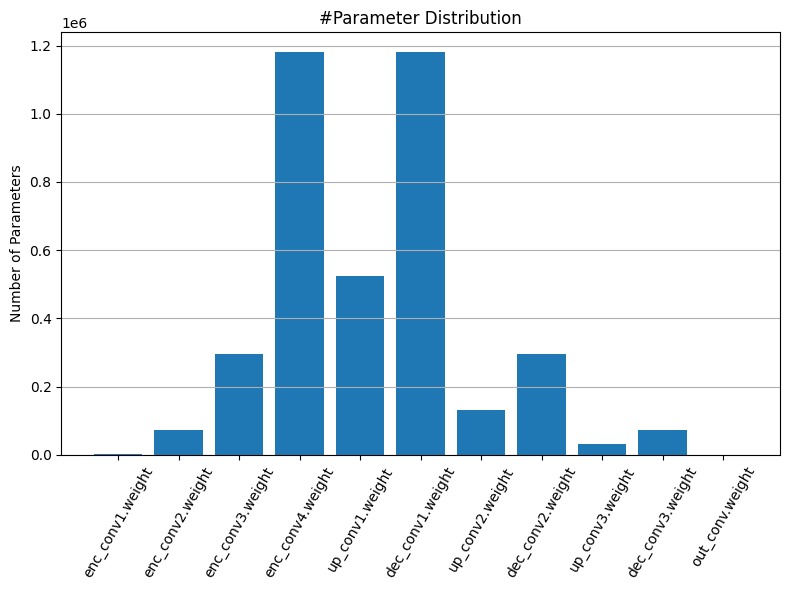

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    # Step 1: calculate the #zeros (please use round())
    nonzero_elements = torch.count_nonzero(torch.round(tensor)).item()
    num_zeros = num_elements - nonzero_elements
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(torch.flatten(importance), round(num_elements*sparsity))
    print(threshold[0])
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold[0]).int()
    print(mask)

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [ ]:
from tqdm.auto import tqdm

@torch.inference_mode()
def evaluate(model: nn.Module,dataloader: DataLoader,verbose=True,) -> float:
    # Switch model to evaluation mode
    model.eval()

    # Initialize variables to track test performance
    test_loss, test_correct, test_pixels = 0, 0, 0
    all_preds, all_labels = [], []

    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_pixels += torch.numel(labels)

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Calculate and print test metrics
    test_loss /= len(test_loader)
    test_acc = test_correct / test_pixels

    return test_acc


@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, test_loader, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/11 weight - enc_conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0709, device='cuda:0')
tensor([[[[1, 1, 1],
          [0, 1, 1],
          [1, 1, 0]],

         [[1, 0, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 0, 1],
          [1, 0, 0],
          [1, 1, 0]]],


        [[[1, 0, 1],
          [0, 1, 1],
          [0, 0, 1]],

         [[1, 1, 1],
          [1, 1, 0],
          [0, 0, 1]],

         [[1, 1, 1],
          [0, 0, 1],
          [0, 0, 0]]],


        [[[1, 1, 0],
          [1, 0, 1],
          [1, 1, 0]],

         [[1, 1, 1],
          [1, 1, 0],
          [0, 0, 1]],

         [[1, 0, 1],
          [0, 0, 1],
          [1, 1, 0]]],


        ...,


        [[[0, 1, 1],
          [0, 0, 1],
          [1, 0, 1]],

         [[0, 0, 0],
          [1, 0, 1],
          [0, 0, 1]],

         [[1, 1, 0],
          [1, 1, 1],
          [1, 0, 0]]],


        [[[0, 0, 1],
          [0, 0, 0],
          [1, 0, 1]],

         [[1, 1, 0],
          [1, 1, 1],
          [1, 0, 0]],

         [[0, 0, 1],
          [1, 

scanning 1/11 weight - enc_conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0149, device='cuda:0')
tensor([[[[1, 1, 1],
          [1, 1, 1],
          [0, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [0, 0, 0]],

         [[0, 1, 0],
          [1, 1, 1],
          [1, 1, 1]],

         ...,

         [[1, 0, 0],
          [0, 1, 1],
          [0, 0, 0]],

         [[1, 0, 0],
          [0, 1, 1],
          [0, 0, 1]],

         [[0, 1, 0],
          [0, 0, 1],
          [1, 1, 0]]],


        [[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [0, 1, 1],
          [1, 0, 0]],

         [[1, 0, 0],
          [0, 1, 1],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [1, 0, 1],
          [0, 0, 1]],

         [[0, 1, 0],
          [1, 0, 0],
          [0, 1, 1]],

         [[0, 1, 1],
          [0, 0, 0],
          [1, 0, 0]]],


        [[[0, 0, 1],
          [1, 1, 1],
          [1, 0, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[0, 1, 1],
   

scanning 2/11 weight - enc_conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0097, device='cuda:0')
tensor([[[[1, 1, 1],
          [1, 0, 1],
          [1, 0, 1]],

         [[0, 1, 0],
          [0, 1, 0],
          [0, 1, 1]],

         [[1, 1, 0],
          [1, 0, 1],
          [1, 0, 1]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 0]],

         [[1, 0, 1],
          [0, 1, 0],
          [1, 0, 1]],

         [[1, 0, 1],
          [1, 0, 0],
          [1, 1, 1]]],


        [[[1, 1, 0],
          [0, 1, 0],
          [0, 1, 1]],

         [[1, 0, 1],
          [0, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         ...,

         [[1, 0, 0],
          [1, 1, 0],
          [1, 0, 1]],

         [[0, 0, 0],
          [0, 1, 1],
          [0, 0, 1]],

         [[1, 1, 0],
          [1, 0, 1],
          [0, 0, 0]]],


        [[[1, 1, 1],
          [1, 1, 0],
          [1, 1, 1]],

         [[1, 1, 1],
          [0, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
   

scanning 3/11 weight - enc_conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0046, device='cuda:0')
tensor([[[[1, 1, 1],
          [1, 1, 1],
          [0, 1, 1]],

         [[1, 1, 0],
          [0, 0, 1],
          [1, 1, 0]],

         [[1, 0, 1],
          [1, 1, 0],
          [1, 0, 1]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [0, 1, 1]],

         [[1, 1, 1],
          [1, 0, 0],
          [1, 1, 1]],

         [[1, 1, 1],
          [0, 1, 1],
          [1, 1, 1]]],


        [[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 1]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 1]],

         [[1, 0, 1],
          [1, 0, 1],
          [1, 0, 1]],

         ...,

         [[0, 0, 0],
          [1, 1, 1],
          [0, 0, 1]],

         [[1, 0, 1],
          [1, 1, 1],
          [1, 0, 0]],

         [[0, 0, 0],
          [1, 1, 1],
          [1, 1, 1]]],


        [[[1, 1, 1],
          [1, 1, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [1, 0, 1],
          [1, 0, 0]],

         [[1, 1, 1],
   

scanning 4/11 weight - up_conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0040, device='cuda:0')
tensor([[[[1, 1],
          [1, 0]],

         [[1, 1],
          [1, 1]],

         [[0, 0],
          [1, 1]],

         ...,

         [[1, 1],
          [1, 1]],

         [[1, 0],
          [1, 1]],

         [[1, 1],
          [1, 1]]],


        [[[0, 1],
          [0, 0]],

         [[1, 1],
          [0, 1]],

         [[1, 0],
          [0, 0]],

         ...,

         [[1, 1],
          [1, 1]],

         [[0, 0],
          [0, 1]],

         [[0, 1],
          [0, 0]]],


        [[[1, 0],
          [1, 0]],

         [[1, 1],
          [1, 1]],

         [[1, 0],
          [1, 1]],

         ...,

         [[1, 1],
          [0, 1]],

         [[1, 0],
          [1, 1]],

         [[1, 1],
          [1, 1]]],


        ...,


        [[[1, 1],
          [0, 0]],

         [[0, 1],
          [1, 1]],

         [[0, 0],
          [1, 1]],

         ...,

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [0, 1]],

         [[1,

scanning 5/11 weight - dec_conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0027, device='cuda:0')
tensor([[[[0, 1, 1],
          [0, 1, 1],
          [0, 0, 0]],

         [[0, 1, 0],
          [1, 0, 0],
          [1, 1, 1]],

         [[0, 0, 0],
          [0, 0, 0],
          [1, 0, 0]],

         ...,

         [[1, 1, 0],
          [1, 1, 0],
          [1, 1, 0]],

         [[0, 0, 0],
          [1, 0, 0],
          [0, 0, 1]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 0, 1]],

         [[1, 1, 1],
          [1, 0, 0],
          [1, 0, 0]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 0]],

         [[0, 1, 0],
          [1, 1, 1],
          [0, 1, 1]],

         [[0, 1, 1],
          [0, 0, 0],
          [0, 1, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[1, 1, 1],
          [0, 0, 0],
          [0, 0, 1]],

         [[0, 0, 0],
   

scanning 6/11 weight - up_conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0060, device='cuda:0')
tensor([[[[0, 1],
          [1, 1]],

         [[1, 0],
          [1, 1]],

         [[1, 0],
          [0, 0]],

         ...,

         [[0, 1],
          [0, 0]],

         [[0, 0],
          [1, 1]],

         [[0, 0],
          [1, 0]]],


        [[[0, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[0, 0],
          [1, 0]],

         ...,

         [[1, 1],
          [1, 1]],

         [[0, 0],
          [0, 1]],

         [[1, 1],
          [0, 0]]],


        [[[1, 0],
          [1, 1]],

         [[1, 0],
          [1, 1]],

         [[0, 0],
          [0, 1]],

         ...,

         [[1, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]]],


        ...,


        [[[1, 1],
          [1, 0]],

         [[0, 0],
          [0, 1]],

         [[0, 1],
          [0, 0]],

         ...,

         [[0, 1],
          [1, 1]],

         [[0, 1],
          [0, 1]],

         [[0,

scanning 7/11 weight - dec_conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0057, device='cuda:0')
tensor([[[[1, 1, 1],
          [0, 1, 1],
          [0, 1, 1]],

         [[1, 1, 1],
          [1, 0, 0],
          [1, 1, 1]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 1]],

         ...,

         [[1, 0, 1],
          [0, 0, 1],
          [0, 1, 0]],

         [[1, 0, 1],
          [0, 1, 0],
          [1, 0, 1]],

         [[0, 0, 0],
          [0, 1, 0],
          [0, 1, 0]]],


        [[[1, 1, 1],
          [1, 0, 1],
          [1, 1, 0]],

         [[1, 1, 0],
          [0, 1, 0],
          [1, 1, 1]],

         [[0, 1, 1],
          [1, 0, 0],
          [1, 0, 1]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 0, 1]],

         [[0, 1, 0],
          [1, 1, 0],
          [1, 1, 0]]],


        [[[1, 0, 1],
          [1, 1, 0],
          [1, 0, 0]],

         [[1, 0, 1],
          [1, 1, 1],
          [1, 0, 0]],

         [[0, 0, 0],
   

scanning 8/11 weight - up_conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0204, device='cuda:0')
tensor([[[[0, 0],
          [1, 0]],

         [[0, 0],
          [1, 1]],

         [[1, 0],
          [0, 1]],

         ...,

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [1, 0]],

         [[0, 1],
          [1, 0]]],


        [[[0, 0],
          [1, 0]],

         [[1, 1],
          [1, 1]],

         [[1, 0],
          [1, 0]],

         ...,

         [[0, 1],
          [1, 1]],

         [[0, 1],
          [1, 1]],

         [[1, 1],
          [0, 1]]],


        [[[1, 1],
          [1, 1]],

         [[0, 0],
          [1, 0]],

         [[0, 0],
          [0, 1]],

         ...,

         [[1, 1],
          [1, 0]],

         [[1, 1],
          [1, 1]],

         [[0, 1],
          [1, 1]]],


        ...,


        [[[0, 0],
          [0, 1]],

         [[0, 0],
          [0, 0]],

         [[1, 1],
          [1, 0]],

         ...,

         [[1, 0],
          [1, 1]],

         [[0, 0],
          [0, 0]],

         [[0,

scanning 9/11 weight - dec_conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0., device='cuda:0')
tensor([[[[1, 1, 0],
          [0, 0, 0],
          [1, 0, 1]],

         [[1, 0, 0],
          [1, 0, 1],
          [1, 0, 0]],

         [[1, 0, 1],
          [0, 0, 1],
          [1, 1, 0]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 0],
          [1, 1, 1]]],


        [[[1, 1, 1],
          [1, 1, 1],
          [1, 0, 1]],

         [[1, 0, 0],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 0, 1],
          [1, 0, 0],
          [1, 0, 1]],

         ...,

         [[1, 1, 0],
          [1, 1, 0],
          [1, 0, 1]],

         [[1, 1, 1],
          [1, 0, 1],
          [0, 0, 0]],

         [[1, 1, 0],
          [1, 1, 0],
          [0, 0, 1]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [1, 0, 0]],

         [[0, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 0],
       

scanning 10/11 weight - out_conv.weight:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(0.0696, device='cuda:0')
tensor([[[[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[0]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[0]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[0]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[1]],

         [[1]],

         [[0]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[0]],

         [[1]],

         [[1]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[1]],

         [[0]],

         [[1]],

         [[0]],

         [[0]],

         [[1]],

         [[1]],

         [[1]],


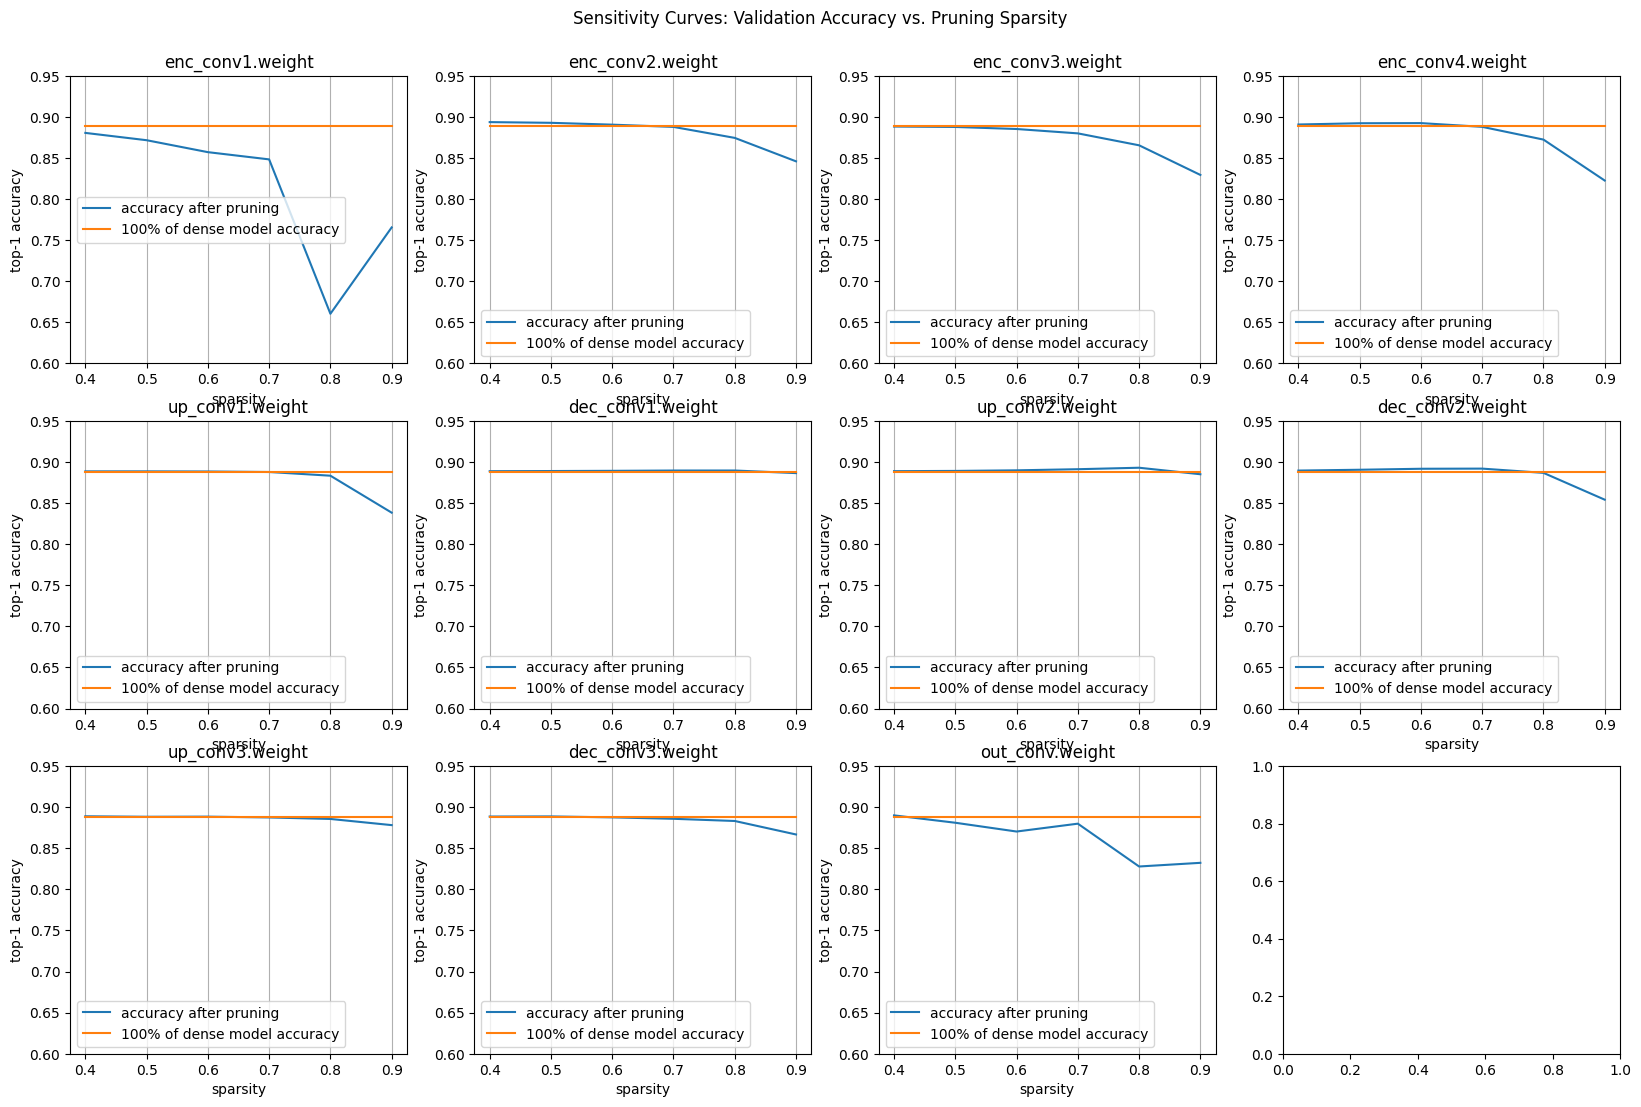

In [ ]:
import math

def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = dense_model_accuracy# 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(20,12))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(0.60, 0.95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    # fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, test_acc)

In [ ]:
sparsity_dict = {
    'enc_conv1.weight': 0.2,  # 20% sparsity
    'enc_conv2.weight': 0.25, # 25% sparsity
    'enc_conv3.weight': 0.6,  # 30% sparsity
    'enc_conv4.weight': 0.6, # 35% sparsity
    'up_conv1.weight': 0.8,   # 20% sparsity
    'dec_conv1.weight': 0.5, # 25% sparsity
    'up_conv2.weight': 0.3,   # 30% sparsity
    'dec_conv2.weight': 0.35, # 35% sparsity
    'up_conv3.weight': 0.4,   # 40% sparsity
    'dec_conv3.weight': 0.45, # 45% sparsity
    'out_conv.weight': 0.5    # 50% sparsity
}

dense_model_size = get_model_size(model)
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

# Fine-tuning Function
def fine_tune_model(model_to_fine_tune, epochs):
    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(epochs):
        model_to_fine_tune.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model_to_fine_tune(images) #['out']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Evaluation after each epoch
        model_to_fine_tune.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model_to_fine_tune(images) #['out']
                _, predicted = torch.max(output.data, 1)
                total += torch.numel(labels)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')


# Fine-tune the pruned model
fine_tune_model(model, epochs=10)

sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")


dense model has size=14.46 MiB
tensor(0.0213, device='cuda:0')
tensor([[[[1, 1, 1],
          [1, 1, 1],
          [1, 0, 0]],

         [[1, 0, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [0, 1, 1]]],


        [[[0, 1, 1],
          [1, 1, 1],
          [1, 0, 1]],

         [[1, 1, 1],
          [1, 1, 0],
          [1, 1, 0]],

         [[1, 1, 1],
          [0, 1, 1],
          [0, 1, 1]]],


        [[[0, 1, 1],
          [1, 1, 1],
          [1, 0, 0]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 0, 1],
          [1, 1, 1],
          [0, 1, 1]]],


        ...,


        [[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 0]],

         [[0, 0, 1],
          [1, 1, 0],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 0]]],


        [[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 0],
          [0, 1, 1],
          [0, 1, 1]],

    

In [ ]:
torch.save(model.state_dict(), '/content/pruned_model.pth')

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [ ]:
from fast_pytorch_kmeans import KMeans
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        n_clusters = 2**bitwidth
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)

    quantized_tensor = codebook.centroids[codebook.labels].clone().detach()

    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [ ]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, test_loader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=3.62 MiB
    8-bit k-means quantized model has accuracy=0.88%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=1.81 MiB
    4-bit k-means quantized model has accuracy=0.72%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=0.90 MiB
    2-bit k-means quantized model has accuracy=0.70%


In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()


In [ ]:
# Fine-tuning Function
def fine_tune_model_v2(model_to_fine_tune, epochs, callbacks=None) -> None:
    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    model_to_fine_tune.train()
    for epoch in range(epochs):
        model_to_fine_tune.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Apply quantization
            quantizer.apply(model_to_fine_tune, update_centroids=True)
            output = model_to_fine_tune(images) #['out']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            if callbacks is not None:
              for callback in callbacks:
                  callback()

In [ ]:
import copy
accuracy_drop_threshold = 0.05
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers
model = UNet_V2().to(device)
model.load_state_dict(torch.load('/content/pruned_model.pth'))

for bitwidth in [8, 4, 2]:
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, test_loader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = test_acc - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            fine_tune_model_v2(model, 5, callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, test_loader)
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = test_acc - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")
    if bitwidth == 8:
      torch.save(model.state_dict(), '/content/pruned_quantized_8_bit_model.pth')
    if bitwidth == 4:
      torch.save(model.state_dict(), '/content/pruned_quantized_4_bit_model.pth')
    if bitwidth == 2:
      torch.save(model.state_dict(), '/content/pruned_quantized_2_bit_model.pth')


k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=3.62 MiB
    8-bit k-means quantized model has accuracy=0.88% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.03% is smaller than threshold=0.05%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=1.81 MiB
    4-bit k-means quantized model has accuracy=0.72% before quantization-aware training 
        Quantization-aware training due to accuracy drop=0.19% is larger than threshold=0.05%
        Epoch 0 Accuracy 0.91% / Best Accuracy: 0.91%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=0.90 MiB
    2-bit k-means quantized model has accuracy=0.24% before quantization-aware training 
        Quantization-aware training due to accuracy drop=0.67% is larger than threshold=0.05%
        Epoch 0 Accuracy 0.89% / Best Accuracy: 0.89%
